In [61]:
include("../../ForecastingMainNew.jl");
include("../../../LogLoss/RealRealHighDimension.jl");
using JLD2
using LaTeXStrings

# Simple Synthetic Interpolation/Forecasting

# (1) Train MPS

Load in the saved dataset.

In [22]:
# loaded_dset = jldopen("simple_noisy_sine.jld2", "r")
# X_train = read(loaded, "X_train")
# y_train = read(loaded, "y_train")
# X_test = read(loaded, "X_test")
# y_test = read(loaded, "y_test")
# X_val = X_test # this is fine because we aren't doing any param optimisation, or any rigorous testing
# y_val = y_test

Set up training parameters.

In [23]:
# setprecision(BigFloat, 128)
# Rdtype = Float64

# verbosity = 0
# track_cost = false

# encoding = fourier()
# encode_classes_separately = true
# train_classes_separately = true

# #encoding = Basis("Legendre")
# dtype = encoding.iscomplex ? ComplexF64 : Float64

# opts=Options(; nsweeps=20, chi_max=25, update_iters=1, verbosity=verbosity, dtype=dtype, loss_grad=loss_grad_KLD,
# bbopt=BBOpt("CustomGD"), track_cost=track_cost, eta=0.05, rescale = (false, true), d=12, aux_basis_dim=2, encoding=encoding, 
# encode_classes_separately=encode_classes_separately, train_classes_separately=train_classes_separately)

Train.

In [24]:
# print_opts(opts)
# W, info, train_states, test_states = fitMPS(X_train, y_train, X_val, y_val, X_test, y_test; random_state=456, chi_init=4, opts=opts, test_run=false)
# print_opts(opts)
# summary = get_training_summary(W, train_states.timeseries, test_states.timeseries; print_stats=true);
# sweep_summary(info)

# (2) Interpolation

Load in the trained mps and opts.

In [2]:
dloc = "legendre_chi_45_d_12.jld2"
legendre_file = jldopen(dloc, "r")
X_test_scaled = read(legendre_file, "X_test_scaled")

100×100 Matrix{Float64}:
 -0.881216  -0.767596  -0.698504  -0.56732   …  0.371054  0.479744  0.652458
 -0.480158  -0.591498  -0.700477  -0.689813     0.907142  0.860218  0.859706
 -0.93891   -0.837833  -0.795994  -0.681256     0.296328  0.366779  0.368213
 -0.302796  -0.361235  -0.460967  -0.472067     0.972116  0.939058  0.954094
 -0.608022  -0.646768  -0.748218  -0.788471     0.889527  0.878725  0.826889
 -0.71922   -0.735334  -0.786538  -0.90051   …  0.800402  0.796865  0.736637
 -0.430033  -0.358538  -0.341259  -0.403408     0.920351  0.929716  0.967571
 -0.849626  -0.874102  -0.885411  -0.935467     0.733315  0.71224   0.590352
 -0.495897  -0.292369  -0.306725  -0.290739     0.771738  0.846437  0.836221
 -0.753132  -0.876532  -0.852265  -0.912928     0.794893  0.780897  0.668096
  ⋮                                          ⋱                      
 -0.313685  -0.255729  -0.35709   -0.445057     0.921234  0.946439  0.975432
 -0.948904  -0.93554   -0.949663  -0.898187     0.581153  0

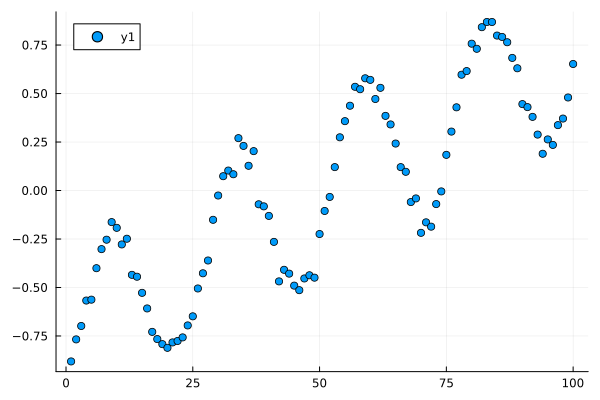

In [65]:
scatter(X_test_scaled[1,:])

In [45]:
kernel = SE(1.0,1.0) + Periodic(1.0,1.0,25.0)

Type: SumKernel{SEIso{Float64}, Periodic{Float64}}
  Type: SEIso{Float64}, Params: [1.0, 1.0]  Type: Periodic{Float64}, Params: [1.0, 1.0, 25.0]

In [46]:
x_train = float(collect(1:50))
y_train = X_test_scaled[1, 1:50]
x_test = float(collect(51:100))
y_test = X_test_scaled[1, 51:100];

In [50]:
gp = GP(x_train, y_train, MeanZero(), kernel, -2.0)
optimize!(gp)

LinearAlgebra.PosDefException(10)


 * Status: success

 * Candidate solution
    Final objective value:     -5.541736e+01

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 4.65e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.86e-10 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.13e-13 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.85e-15 ≰ 0.0e+00
    |g(x)|                 = 1.54e-11 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    11
    f(x) calls:    34
    ∇f(x) calls:   34


In [48]:
μ, Σ = predict_y(gp,x_test);

In [52]:
dloc = "legendre_chi_20_d_6.jld2";
fc = load_forecasting_info(dloc);

┌ Warning: type Main.#9#10{Bool} does not exist in workspace; reconstructing
└ @ JLD2 /Users/joshua/.julia/packages/JLD2/VWinU/src/data/reconstructing_datatypes.jl:621


MethodError: MethodError: Cannot `convert` an object of type JLD2.ReconstructedStatic{Symbol("#9#10{Bool}"), (:norm,), Tuple{Bool}} to an object of type Function

Closest candidates are:
  convert(::Type{T}, !Matched::T) where T
   @ Base Base.jl:84


Loop over different horizon lengths and compute the mean MAE across the entire test set. Record the best example at each evaluation. This was run in the REPL becuase it is much faster, and the results have been saved and loaded in below.

In [7]:
t_vals = collect(1:2:99) 
best_idx = Vector{Float64}(undef, length(t_vals))
mean_score = Vector{Float64}(undef, length(t_vals))
std_score = Vector{Float64}(undef, length(t_vals))
for (i, t) in enumerate(t_vals)
    println("Evaluating t = $t")
    class_scores = forecast_all(fc, :directMean, (100-t); metric=:MAE);
    best_score_idx = argmin(class_scores[1])
    best_idx[i] = best_score_idx
    mean_score_class = mean(class_scores[1])
    mean_score[i] = mean_score_class
    std_score_class = std(class_scores[1])
    std_score[i] = std_score_class
    println("mean score: $mean_score_class")
end

Evaluating t = 5
There are 1 classes. Evaluating all...
mean score: 0.11263885340867238
Evaluating t = 10
There are 1 classes. Evaluating all...
mean score: 0.0636459548209484
Evaluating t = 15
There are 1 classes. Evaluating all...
mean score: 0.06559048226828691
Evaluating t = 20
There are 1 classes. Evaluating all...
mean score: 0.062019339602764886
Evaluating t = 25
There are 1 classes. Evaluating all...


Load in saved results for $\chi = 45$

In [76]:
l_45 = jldopen("simple_noisy_sine_legendre_chi45_d12v2_results.jld2", "r")
mean_l45 = read(l_45, "mean_score")
best_l45 = read(l_45, "best_idx")
std_l45 = read(l_45, "std_score")
t_vals = read(l_45, "t_vals");

Load in saved results for $\chi = 20$

In [78]:
l_20 = jldopen("simple_noisy_sine_legendre_chi20_d12_results.jld2", "r")
mean_l20 = read(l_20, "mean_score")
best_l20 = read(l_20, "best_idx")
t_vals = read(l_20, "t_vals");

Load in saved results for $\chi = 10$

In [107]:
l_10 = jldopen("simple_noisy_sine_legendre_chi10_d12_results.jld2", "r")
mean_l10 = read(l_10, "mean_score")
std_l10 = read(l_10, "std_score")
best_l10 = read(l_10, "best_idx")
t_vals = read(l_10, "t_vals");

Plot all three different chi values for comparison

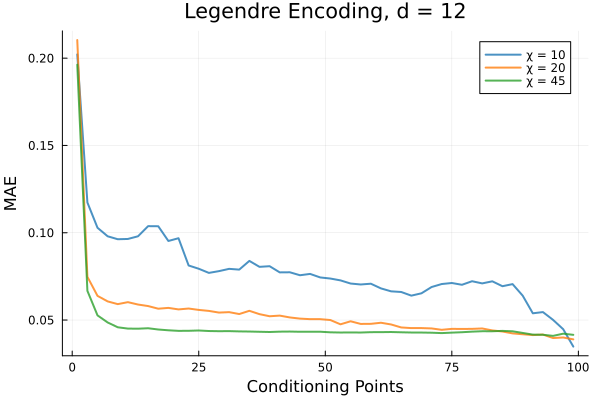

In [113]:
plot(t_vals, mean_l10, label="χ = 10", lw=2, ylabel="MAE", 
    xlabel="Conditioning Points", color=palette(:tab10)[1], 
    title="Legendre Encoding, d = 12", alpha=0.8)
#scatter!(t_vals, mean_score, color=palette(:tab10)[1], label="", ms=3)
plot!(t_vals, mean_l20, label="χ = 20", lw=2, color=palette(:tab10)[2], alpha=0.8)
plot!(t_vals, mean_l45, label="χ = 45", lw=2, color=palette(:tab10)[3], alpha=0.8)
#savefig("simple_noisy_sine_legendre_combined.svg")

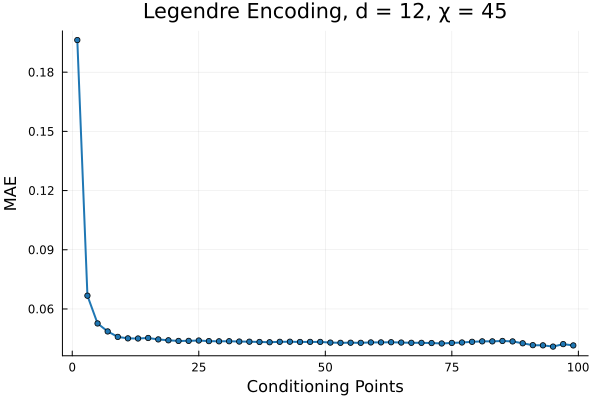

In [80]:
plot(t_vals, mean_l45, label="", lw=2, ylabel="MAE", 
    xlabel="Conditioning Points", color=palette(:tab10)[1], 
    title="Legendre Encoding, d = 12, χ = 45")
scatter!(t_vals, mean_l45, label="", color=palette(:tab10)[1],
    ms=3)
#savefig("simple_noisy_sine_legendre_d12chi45_2.svg")

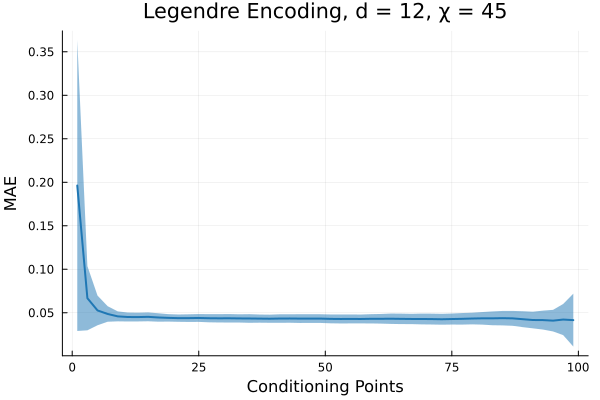

In [115]:
plot(t_vals, mean_l45, label="", lw=2, ylabel="MAE", 
    xlabel="Conditioning Points", color=palette(:tab10)[1], 
    title="Legendre Encoding, d = 12, χ = 45", ribbon=std_l45)

Plot some examples using the best performing for each given conditioning pts interval

In [104]:
println("t_val: $(t_vals[3]), index: $(Int(best_l45[3]))")
println("t_val: $(t_vals[8]), index: $(Int(best_l45[8]))")
println("t_val: $(t_vals[13]), index: $(Int(best_l45[13]))")
println("t_val: $(t_vals[23]), index: $(Int(best_l45[23]))")
println("t_val: $(t_vals[33]), index: $(Int(best_l45[33]))")
println("t_val: $(t_vals[43]), index: $(Int(best_l45[43]))")
println("t_val: $(t_vals[48]), index: $(Int(best_l45[48]))")

t_val: 5, index: 69
t_val: 15, index: 93
t_val: 25, index: 69
t_val: 45, index: 81
t_val: 65, index: 81
t_val: 85, index: 81
t_val: 95, index: 66


# Different ds, chi = 45

In [116]:
l_chi45_d16 = jldopen("/Users/joshua/Desktop/QTNML_paper/QuantumInspiredML/Interpolation/paper/simple-synthetic/results/simple_noisy_sine_legendre_chi45_d16_results.jld2", "r")
mean_chi45_d16 = read(l_chi45_d16, "mean_score")
std_chi45_d16 = read(l_chi45_d16, "std_score")
best_chi45_d16 = read(l_chi45_d16, "best_idx")
t_vals = read(l_chi45_d16, "t_vals");

In [126]:
l_chi45_d8 = jldopen("/Users/joshua/Desktop/QTNML_paper/QuantumInspiredML/Interpolation/paper/simple-synthetic/results/simple_noisy_sine_legendre_chi45_d8_results.jld2", "r")
mean_chi45_d8 = read(l_chi45_d8, "mean_score")
std_chi45_d8 = read(l_chi45_d8, "std_score")
best_chi45_d8 = read(l_chi45_d8, "best_idx")
t_vals = read(l_chi45_d8, "t_vals");

In [129]:
l_chi45_d4 = jldopen("/Users/joshua/Desktop/QTNML_paper/QuantumInspiredML/Interpolation/paper/simple-synthetic/results/simple_noisy_sine_legendre_chi45_d4_results.jld2", "r")
mean_chi45_d4 = read(l_chi45_d4, "mean_score")
std_chi45_d4 = read(l_chi45_d4, "std_score")
best_chi45_d4 = read(l_chi45_d4, "best_idx")
t_vals = read(l_chi45_d4, "t_vals");

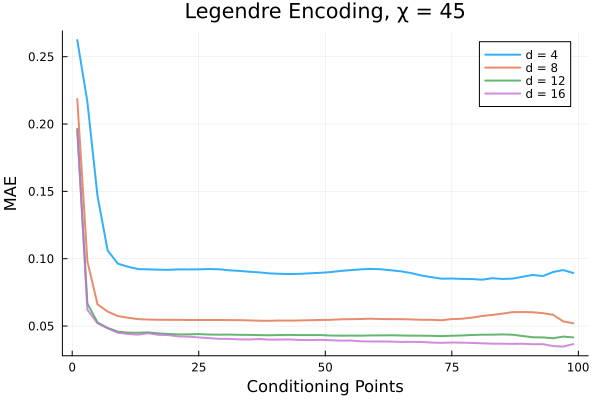

In [139]:
plot(t_vals, mean_chi45_d4, label = "d = 4", lw=2, alpha=0.8, xlabel="Conditioning Points",
    title="Legendre Encoding, χ = 45", ylabel="MAE")
plot!(t_vals, mean_chi45_d8, label = "d = 8", lw=2, alpha=0.8)
plot!(t_vals, mean_l45, label = "d = 12", lw=2, alpha=0.8)
plot!(t_vals, mean_chi45_d16, label="d = 16", 
   lw=2, alpha=0.8)
#savefig("plots/d_compare/legendre_chi45_d_compare.svg")